In [238]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import time
%matplotlib inline

In [310]:
#ПОДГОТОВКА ДАННЫХ
from sklearn.model_selection import train_test_split

X = pd.read_csv('weather.csv')
#Создание выборки ответов
y = X.RainTomorrow.replace({'No':-1, 'Yes': 1})
del X['RainTomorrow']

#Удалим ненужные столбцы
del X['Location']
del X['Unnamed: 0']
del X['WindDir3pm']
del X['WindDir9am']

X.RainToday = X.RainToday.replace({'No' : -1, 'Yes' : 1})

# Закодируем поля направления ветра и преобразуем значение даты
X.Date = pd.to_datetime(X.Date)

oheWindGustDir = pd.get_dummies(X['WindGustDir'])
X = X.join(oheWindGustDir)
del X['WindGustDir']
del X['Date']

# Заполним все поля средним значением
numeric_data = X.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns
X = X.fillna(numeric_data_mean)

In [311]:
scaler = preprocessing.MinMaxScaler()
X_scale = scaler.fit_transform(X)
X = pd.DataFrame(X_scale, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [312]:
#logistic regression
regress = LogisticRegression()
regress.fit(X_train, y_train)
weights = np.array(regress.coef_)
regressWeights = weights.reshape(weights.shape[1])

In [332]:
#KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

[ 1 -1 -1 -1 -1 -1]


KeyboardInterrupt: 

In [314]:
# Naive Bayes
naive = GaussianNB()
naive.fit(X_train, y_train)

GaussianNB()

In [326]:
def probability(theta, x):
    scalMul = x.dot(theta)
    if scalMul > 5:
        return 1
    if scalMul < -5:
        return 0
    return 1/(1 + np.exp(-scalMul))

def binary_class_prediction(theta, X):
    xOut = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        prob = probability(theta, X[i])
        if prob > 0.5:
            xOut[i] = 1
        else:
            xOut[i] = -1
    return xOut

def logLoss(label, theta, X):
    sumLoss = 0
    for i in range(X.shape[0]):
        exp = 1+np.exp(-label[i] * X[i].dot(theta))
        sumLoss += np.log(exp)
    return (sumLoss/X.shape[0])

def gradient(theta, X, y):
    grad = np.zeros_like(theta)
    xSize = X.shape[0]
    for i in range(xSize):
        if y[i] == 1:
            prob = -probability(-theta, X[i])
        else:
            prob = probability(theta, X[i])
        for j in range(grad.size):
            grad[j] += X[i,j]*prob

    grad /= xSize
    return grad

In [327]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)

    errors = []

    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]

    # plt
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')

    for _ in range(iters):

        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)

        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'


        # Обновляем веса

        theta -= grad * h

        theta_history = np.vstack((theta_history, theta))

        # error
        loss = logLoss(y, theta, X)
        errors.append(loss)

        if plot:
            ax1.clear()
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')


            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax3.set_ylabel('loss')
            ax2.set_xlabel('iterations')

            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('iterations')
            fig.canvas.draw()

    return theta

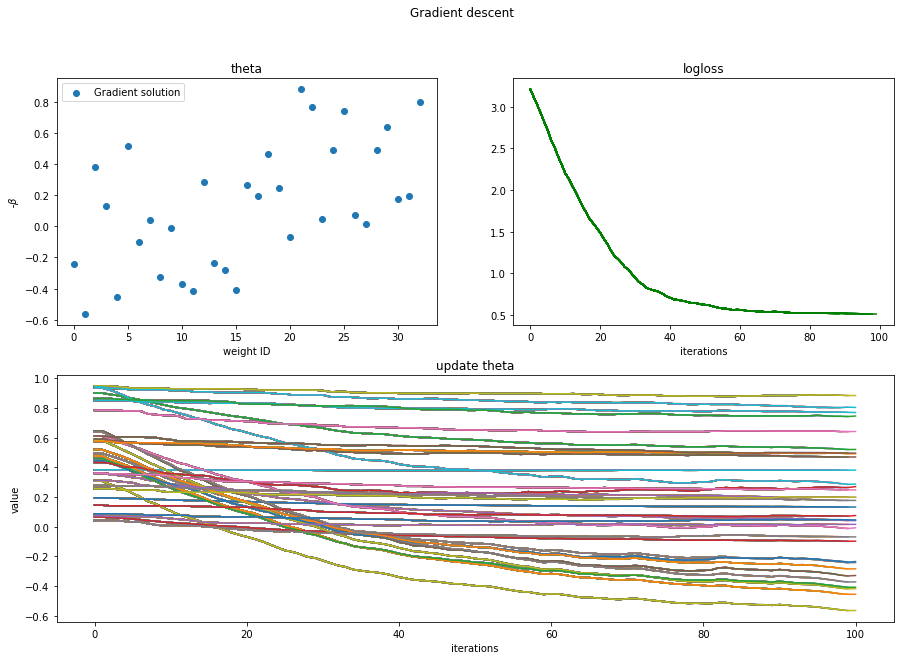

In [329]:
optimal_theta = fit(X_train, y_train)

Sklearn logistic regression: 
Roc auc score: 0.7207793331412001
Custom LogLoss : 1.4934844084763965
Sklearn LogLoss : 5.346203466845729

Naive Bauess
Roc auc score: 0.7273381262269334
Sklearn LogLoss : 7.48984444216763

KNN
Roc auc score: 0.7273381262269334
Sklearn LogLoss : 7.48984444216763

Custom logistic regression
Roc auc score: 0.5051246466727989
Custom LogLoss : 0.5058042738858671
Sklearn LogLoss : 7.5917545074347865


<AxesSubplot:title={'center':'Custom logistic regression'}>

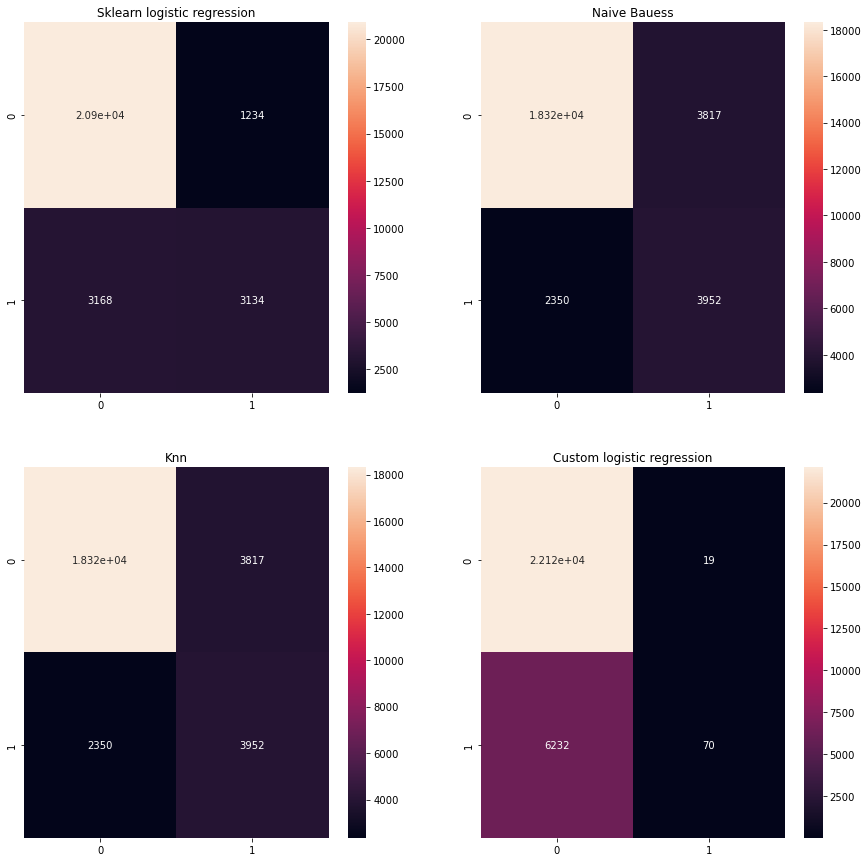

In [341]:
#Оценка качества работы моделей
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("Sklearn logistic regression")
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("Naive Bauess")
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("Knn")
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title("Custom logistic regression")

print("Sklearn logistic regression: ")
print("Roc auc score: " + str(roc_auc_score(y_test, (regress.predict(X_test)))))
print("Custom LogLoss : " + str(logLoss(y_test, regressWeights, X_test)))
print("Sklearn LogLoss : " + str(log_loss(y_test, (regress.predict(X_test)))))
cf_matrix = confusion_matrix(y_test, regress.predict(X_test))
ax1 = sns.heatmap(cf_matrix, annot=True, fmt='.4g', ax=ax1)

print("\nNaive Bauess")
print("Roc auc score: " + str(roc_auc_score(y_test, (naive.predict(X_test)))))
print("Sklearn LogLoss : " + str(log_loss(y_test, (naive.predict(X_test)))))
cf_matrix = confusion_matrix(y_test, naive.predict(X_test))
sns.heatmap(cf_matrix, annot=True, fmt='.4g', ax=ax2)

print("\nKNN")
print("Roc auc score: " + str(roc_auc_score(y_test, (naive.predict(X_test)))))
print("Sklearn LogLoss : " + str(log_loss(y_test, (naive.predict(X_test)))))
cf_matrix = confusion_matrix(y_test, naive.predict(X_test))
sns.heatmap(cf_matrix, annot=True, fmt='.4g', ax=ax3)

print("\nCustom logistic regression")
print("Roc auc score: " + str(roc_auc_score(y_test, (binary_class_prediction(optimal_theta, X_test)))))
print("Custom LogLoss : " + str(logLoss(y_test, optimal_theta, X_test)))
print("Sklearn LogLoss : " + str(log_loss(y_test, (binary_class_prediction(optimal_theta, X_test)))))
cf_matrix = confusion_matrix(y_test, binary_class_prediction(optimal_theta, X_test))
sns.heatmap(cf_matrix, annot=True, fmt='.4g', ax=ax4)